In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install folium==0.2.1
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 4.0 MB/s 
  Created wheel for folium: filename=folium-0.2.1-py3-none-any.whl size=79808 sha256=b3fade1e88c98682007b17619550c834b15372f1aef30d7c0e8deee3f03bf19c
  Stored in directory: /root/.cache/pip/wheels/9a/f0/3a/3f79a6914ff5affaf50cabad60c9f4d565283283c97f0bdccf
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [3]:
!pip install -q transformers
!pip install -q datasets

     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 44.1 MB/s 
     |████████████████████████████████| 101 kB 12.5 MB/s 
     |████████████████████████████████| 596 kB 60.9 MB/s 
     |████████████████████████████████| 362 kB 5.3 MB/s 
     |████████████████████████████████| 140 kB 68.6 MB/s 
     |████████████████████████████████| 212 kB 70.3 MB/s 
     |████████████████████████████████| 1.1 MB 56.6 MB/s 
     |████████████████████████████████| 127 kB 74.0 MB/s 
     |████████████████████████████████| 144 kB 62.9 MB/s 
     |████████████████████████████████| 94 kB 2.6 MB/s 
     |████████████████████████████████| 271 kB 70.7 MB/s 


In [4]:
import torch
from datasets import load_dataset
import pandas as pd
import collections
from datasets import load_dataset , load_metric
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import TrainingArguments, Trainer
from transformers import default_data_collator

In [5]:
#dataset = load_dataset("Shayanvsf/ParSQuAD") # two available modes
dataset = load_dataset("Shayanvsf/pquad_public")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/c398ba29001242851de4d8dc468625e7eeccc2041e8168871e972293b3745bde


Generating validation split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/d87772b342fcc0d549d5a7a63e6b8873e2ae95e5c07919932e587397f545910d


Generating test split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/e6f3da0212a37e85850d4f58a11a3e7bff446fcd83b57e8aeb54bbafa8ed95c8
Dataset pquad_public downloaded and prepared to /root/.cache/huggingface/datasets/Shayanvsf___pquad_public/pquad_public/1.0.0/20f4f02802eb56c6b1f41e0fd9e4b3452884817ce8592df8fe863576c1569264. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 7878
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1157
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 964
    })
})

In [7]:
# dataset['train'] = dataset['train'].remove_columns("id")
# dataset['validation'] = dataset['validation'].remove_columns("id")

In [8]:
# new_column_train = range(0,len(dataset['train']))
# dataset['train'] = dataset['train'].add_column('id',new_column_train)
# new_column_validation = range(0,len(dataset['validation']))
# dataset['validation'] = dataset['validation'].add_column('id',new_column_validation)

#Loading datasets

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 7878
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 1157
    })
    test: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 964
    })
})

In [10]:
# dataset_eval

## Train Data

In [11]:
pd.DataFrame(data = dataset['train']).head()

,id,title,context,question,answers
0,874587.0,عبّاس میرزا,عبّاس میرزا (۴ ذی‌الحجهٔ ۱۲۰۳ ه‍.ق/۲۶ اوت ۱۷۸۹...,عبّاس میرزا در چه تاریخی به دنیا آمد؟,{'text': ['۴ ذی‌الحجهٔ ۱۲۰۳ ه‍.ق/۲۶ اوت ۱۷۸۹ م...
1,874588.0,عبّاس میرزا,عبّاس میرزا (۴ ذی‌الحجهٔ ۱۲۰۳ ه‍.ق/۲۶ اوت ۱۷۸۹...,عبّاس میرزا در چه تاریخی درگذشت؟,{'text': ['۱۰ جمادی‌الثانی ۱۲۴۹ ه‍.ق/۲۵ اکتبر ...
2,874589.0,عبّاس میرزا,عبّاس میرزا (۴ ذی‌الحجهٔ ۱۲۰۳ ه‍.ق/۲۶ اوت ۱۷۸۹...,عبّاس میرزا که بود؟,{'text': ['نامدار به عبّاس میرزا نایِبُ‌السَّل...
3,874590.0,عبّاس میرزا,عبّاس میرزا (۴ ذی‌الحجهٔ ۱۲۰۳ ه‍.ق/۲۶ اوت ۱۷۸۹...,عبّاس میرزا در چه سال‌هایی ولایتعهدی ایران و ن...,"{'text': ['سال‌های ۱۷۹۷ تا ۱۸۳۳ م'], 'answer_s..."
4,874591.0,عبّاس میرزا,عبّاس میرزا (۴ ذی‌الحجهٔ ۱۲۰۳ ه‍.ق/۲۶ اوت ۱۷۸۹...,عبّاس میرزا فرزند کدام پادشاه ایران است؟,"{'text': ['فتحعلی‌شاه'], 'answer_start': [161]}"


## Validation Data

In [12]:
pd.DataFrame(data = dataset['validation']).head()

,id,title,context,question,answers
0,1928644.0,وست‌لایف,وست‌لایف(به انگلیسی: Westlife) یک گروه مشهور ا...,وست‌لایف چیست؟,"{'text': ['یک گروه مشهور ایرلندی', 'یک گروه مش..."
1,1928645.0,وست‌لایف,وست‌لایف(به انگلیسی: Westlife) یک گروه مشهور ا...,وست‌لایف در چه تاریخی به‌طور رسمی بنیان گذاشته...,"{'text': ['۳ ژوئیه سال ۱۹۹۸', 'در ۳ ژوئیه سا..."
2,1928646.0,وست‌لایف,وست‌لایف(به انگلیسی: Westlife) یک گروه مشهور ا...,وست‌لایف با چند عضو سال ۱۹۹۸ به ‌طور رسمی بنی...,"{'text': ['۵', 'با ۵ نفر عضو', '۵ نفر'], 'answ..."
3,1928647.0,وست‌لایف,وست‌لایف(به انگلیسی: Westlife) یک گروه مشهور ا...,وست‌لایف با کدام اعضا به‌طور رسمی بنیان گذاشته...,{'text': ['شین فیلان، مارک فیهلی، نیکی برن، کی...
4,1928648.0,وست‌لایف,وست‌لایف(به انگلیسی: Westlife) یک گروه مشهور ا...,برایان مک فدن در چه تاریخی از وست‌لایف جدا شد؟,"{'text': ['مارس ۲۰۰۴', 'در مارس ۲۰۰۴'], 'answe..."


## Test Data

In [13]:
pd.DataFrame(data = dataset['test']).head()

,id,title,context,question,answers
0,1719422.0,آینتراخت فرانکفورت,این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق...,تیم آینتراخت فرانکفورت در چه سالی تاسیس شد؟,"{'text': ['۱۸۹۹', 'سال ۱۸۹۹', 'در سال ۱۸۹۹'], ..."
1,1719423.0,آینتراخت فرانکفورت,این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق...,تیم آینتراخت فرانکفورت دارای چند عنوان قهرمانی...,"{'text': ['یک'], 'answer_start': [54]}"
2,1719424.0,آینتراخت فرانکفورت,این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق...,تیم آینتراخت فرانکفورت دارای چند عنوان قهرمانی...,"{'text': ['۵'], 'answer_start': [86]}"
3,1719425.0,آینتراخت فرانکفورت,این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق...,ورزشگاه اختصاصی تیم آینتراخت فرانکفورت کجاست؟,{'text': ['ورزشگاه والداستادیون بوده که در سال...
4,1719426.0,آینتراخت فرانکفورت,این تیم در سال ۱۸۹۹ تأسیس شد و تا به حال موفق...,ورزشگاه والداستادیون در سال ۲۰۰۵ به چه نامی تغ...,"{'text': ['کومرتسبانک آرنا'], 'answer_start':..."


## Model Init

In [31]:
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
max_length = 256 #512 # The maximum length of a feature (question and context)
doc_stride = 128 # 256 # The authorized overlap between two part of the context when splitting it is needed.
batch_size = 8
lr = 3e-5
epoch = 3

In [32]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [33]:
tokenizer(".اسمتون چی بود ؟", "اسم من شایان است")

{'input_ids': [2, 15, 58854, 2061, 3069, 2083, 303, 4, 4856, 2078, 9920, 2045, 4], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Create several input features from long contex

In [34]:
for i, example in enumerate(dataset["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > max_length:
        print('Find one')
        break
        
example = dataset["train"][i]

Find one


In [35]:
example

{'answers': {'answer_start': [757],
  'text': ['نوارهای آهنی که به آن\u200cها «چرخ پهن» گفته می\u200cشود']},
 'context': 'تایر، از واژهٔ فرانسوی “tirer” به معنای کشیدن، ریشه گرفته\u200cاست. این نامگذاری به این علت این است که در گذشته تایر به تسمه\u200cهای آهنی و سیم\u200cهای ضخیمی که به دور چرخ\u200cهای کالسکه کشیده می\u200cشد، اطلاق می\u200cشده. در آهنگری به سبک فرانسوی، کلمهٔ تایر یا کشیدن برای ساخت میلهٔ آهنی استفاده می\u200cشده. همچنین این واژه به پروسهٔ ساخت سایر فلزات و نورد نیز اطلاق می\u200cشده. یکی از نخستین دفعاتی که نام تایر در زبان انگلیسی ذکر شد به سال ۱۸۵۳ برمی\u200cگردد. در آن زمان، در مجلهٔ لندن، مقاله\u200cای با عنوان «فواید استفاده از چرخ\u200cهای پهن» چاپ شد. در این مقاله روش متداول حفاظت از چرخ، خم کردن دو میله (که به آن\u200cها تایر گفته می\u200cشود) معرفی شده\u200cبود، که با آن میله\u200cها تسمه ساخته می\u200cشد و سپس آن\u200cها را به چرخ متصل می\u200cکردند؛ ولی همچنین در این مقاله اشاره شده بود که بهتر است به جای میله\u200cها، از نوارهای آهنی که به آن\

In [36]:
len(tokenizer(example["question"], example["context"])["input_ids"])

260

In [37]:
len(tokenizer(example["question"], example["context"], max_length = max_length, truncation="only_second")["input_ids"])

256

## return_overflowing_tokens

In [38]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length = max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [39]:
[len(x) for x in tokenized_example["input_ids"]] 

[256, 165]

In [40]:
len(tokenized_example["input_ids"])

2

In [41]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

[CLS] در مجله لندن مقالهای با عنوان [UNK] فواید استفاده از چرخهای پهن [UNK] چاپ شد اشاره شده بود که بهتر است به جای میلهها از چه چیزی استفاده شود ؟ [SEP] تایر ، از واژه فرانسوی [UNK] tirer [UNK] به معنای کشیدن ، ریشه گرفتهاست. این نامگذاری به این علت این است که در گذشته تایر به تسمههای اهنی و سیمهای ضخیمی که به دور چرخهای کالسکه کشیده میشد ، اطلاق میشده. در اهنگری به سبک فرانسوی ، کلمه تایر یا کشیدن برای ساخت میله اهنی استفاده میشده. همچنین این واژه به پروسه ساخت سایر فلزات و نورد نیز اطلاق میشده. یکی از نخستین دفعاتی که نام تایر در زبان انگلیسی ذکر شد به سال ۱۸۵۳ برمیگردد. در ان زمان ، در مجله لندن ، مقالهای با عنوان [UNK] فواید استفاده از چرخهای پهن [UNK] چاپ شد. در این مقاله روش متداول حفاظت از چرخ ، خم کردن دو میله ( که به انها تایر گفته میشود ) معرفی شدهبود ، که با ان میلهها تسمه ساخته میشد و سپس انها را به چرخ متصل میکردند ؛ ولی همچنین در این مقاله اشاره شده بود که بهتر است به جای میلهها ، از نوارهای اهنی که به انها [UNK] چرخ پهن [UNK] گفته میشود استفاده شود. زیرا میلهها وقتی است

## offset_mapping

In [42]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 2), (3, 7), (8, 12), (13, 21), (22, 24), (25, 30), (31, 32), (32, 37), (38, 45), (46, 48), (49, 56), (57, 60), (60, 61), (62, 65), (66, 68), (69, 74), (75, 78), (79, 82), (83, 85), (86, 90), (91, 94), (95, 97), (98, 101), (102, 109), (110, 112), (113, 115), (116, 120), (121, 128), (129, 132), (132, 133), (0, 0), (0, 4), (4, 5), (6, 8), (9, 13), (15, 22), (23, 24), (24, 27), (27, 29), (29, 30), (31, 33), (34, 39), (40, 45), (45, 46), (47, 51), (52, 61), (61, 62), (63, 66), (67, 75), (76, 78), (79, 82), (83, 86), (87, 90), (91, 94), (95, 97), (98, 100), (101, 106), (107, 111), (112, 114), (115, 119), (120, 123), (124, 129), (130, 131), (132, 139), (140, 145), (146, 148), (149, 151), (152, 155), (156, 163), (164, 170), (171, 176), (177, 182), (182, 183), (184, 189), (190, 196), (196, 197), (198, 200), (201, 208), (209, 211), (212, 215), (216, 223), (223, 224), (225, 229), (231, 235), (236, 238), (239, 244), (245, 249), (250, 254), (255, 259), (261, 266), (267, 274), (275, 281

In [43]:
len(tokenized_example["offset_mapping"])

2

In [44]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

در در


## return 0 if a token is in the question, else return 1.

In [45]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, None]


## Detecting start and end character of a anwser

In [46]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char): # searching in the context
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

202 212


In [47]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

نوارهای اهنی که به انها [UNK] چرخ پهن [UNK] گفته میشود
نوارهای آهنی که به آن‌ها «چرخ پهن» گفته می‌شود


## Putting it all together

In [48]:
def prepare_train_features(examples):
    examples["question"] = [q.lstrip() for q in examples["question"]]
    #Assume padding on the right.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,)
    
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping") #extract overflow_to_sample_mapping
    offset_mapping = tokenized_examples.pop("offset_mapping") #extract offset_mapping
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []
    for i, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])
            # Start token index of the current span in the text.
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1
            # End token index of the current span in the text.
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1
            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [49]:
# the datasets library does cashing itself, batched is multitreading for fast-tokenizer
tokenized_ds = dataset.map(prepare_train_features, batched=True, remove_columns=dataset["train"].column_names)

Parameter 'function'=<function prepare_train_features at 0x7f34db4b8cb0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [50]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initia

In [51]:
model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    output_dir = f"/content/drive/MyDrive/CA6/checkpoints/{model_name}-finetuned-ParSQuAD",
    overwrite_output_dir = True,
    save_strategy = "steps",
    save_steps = 1000,
    evaluation_strategy = "epoch",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epoch,
    weight_decay=0.0001)

In [52]:
data_collator = default_data_collator
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation'],
    tokenizer=tokenizer)

In [53]:
# start training
trainer.train()
#trainer.save_model(trainer.save_model("PersianQA(ParsBERT)-trained"))

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7951
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2982


Epoch,Training Loss,Validation Loss
1,1.865300,1.199281
2,0.620400,1.265515
3,0.269900,1.583766


***** Running Evaluation *****
  Num examples = 1157
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/CA6/checkpoints/bert-base-parsbert-uncased-finetuned-ParSQuAD/checkpoint-1000
Configuration saved in /content/drive/MyDrive/CA6/checkpoints/bert-base-parsbert-uncased-finetuned-ParSQuAD/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/CA6/checkpoints/bert-base-parsbert-uncased-finetuned-ParSQuAD/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/CA6/checkpoints/bert-base-parsbert-uncased-finetuned-ParSQuAD/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/CA6/checkpoints/bert-base-parsbert-uncased-finetuned-ParSQuAD/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1157
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/CA6/checkpoints/bert-base-parsbert-uncased-finetuned-ParSQuAD/checkpoint-2000
Configuration save

TrainOutput(global_step=2982, training_loss=0.7987007074592739, metrics={'train_runtime': 1190.1028, 'train_samples_per_second': 20.043, 'train_steps_per_second': 2.506, 'total_flos': 2687567281062900.0, 'train_loss': 0.7987007074592739, 'epoch': 3.0})

# Evaluation

## Trainer output type

In [54]:
for batch in trainer.get_eval_dataloader():
    break
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}
with torch.no_grad():
    output = trainer.model(**batch)
output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [55]:
output.start_logits.shape, output.end_logits.shape

(torch.Size([8, 101]), torch.Size([8, 101]))

In [56]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([17, 31, 40, 37, 74, 82, 87,  0], device='cuda:0'),
 tensor([20, 34, 42, 59, 75, 82, 89,  0], device='cuda:0'))

## picking the n_best prediction

In [57]:
n_best_size = 20
import numpy as np

start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )

## create validation feature

In [58]:
def prepare_validation_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]
    # print(examples["question"])
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"],
        examples["context"],
        truncation="only_second",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []
    
    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [59]:
# validation_features = dataset["validation"].map(
#     prepare_validation_features,
#     batched=True,
#     remove_columns=dataset["validation"].column_names
# )

In [60]:
test_features = dataset["test"].map(
    prepare_validation_features,
    batched=True,
    remove_columns=dataset["test"].column_names
)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [61]:
test_features

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 995
})

In [62]:
raw_predictions = trainer.predict(test_features)

The following columns in the test set don't have a corresponding argument in `BertForQuestionAnswering.forward` and have been ignored: offset_mapping, example_id. If offset_mapping, example_id are not expected by `BertForQuestionAnswering.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 995
  Batch size = 8


In [63]:
test_features.set_format(type=test_features.format["type"], columns=list(test_features.features.keys()))

## Evaluating model for a single example

In [64]:
max_answer_length = 30
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
offset_mapping = test_features[0]["offset_mapping"]
# The first feature comes from the first example. For the more general case, we will need to be match the example_id to
# an example index
context = dataset["test"][1]["context"]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
        # to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index] is None
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index][1]
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char: end_char]
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 12.916742, 'text': 'شد و تا به'},
 {'score': 8.824779, 'text': 'و تا به'},
 {'score': 8.704322, 'text': 'به'},
 {'score': 8.693544, 'text': 'شد و تا به حال'},
 {'score': 8.01672, 'text': 'شد و'},
 {'score': 6.12284, 'text': 'شد'},
 {'score': 4.6015806, 'text': 'و تا به حال'},
 {'score': 4.481124, 'text': 'به حال'},
 {'score': 3.9247553, 'text': 'و'},
 {'score': 2.3007455, 'text': 'شد و تا به حال موفق'},
 {'score': 0.83033323,
  'text': 'شد و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵'},
 {'score': 0.4180236, 'text': 'شد و تا'},
 {'score': -0.6362519, 'text': 'این تیم در سال ۱۸۹۹ تأسیس شد و تا به'},
 {'score': -1.3153229, 'text': 'تأسیس شد و تا به'},
 {'score': -1.7912188, 'text': 'و تا به حال موفق'},
 {'score': -1.9116755, 'text': 'به حال موفق'},
 {'score': -2.053895, 'text': 'تا به'},
 {'score': -3.261631,
  'text': 'و تا به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان، ۵'},
 {'score': -3.3820877,
  'text': 'به حال موفق به کسب یک عنوان قهرمانی در لیگ آلمان

In [65]:
dataset["test"][1]["answers"]

{'answer_start': [54], 'text': ['یک']}

## feature per example 

In [66]:
# import collections

# examples = dataset["test"]
# features = validation_features

# example_id_to_index = {int(k): i for i, k in enumerate(examples["id"])}
# features_per_example = collections.defaultdict(list)
# for i, feature in enumerate(features):
#     features_per_example[example_id_to_index[feature["example_id"]]].append(i)

## put it all together

In [67]:
from tqdm.auto import tqdm

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size = None , max_answer_length = None):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {int(k): i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        valid_answers = []
        
        context = example["context"]
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index] is None
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text": context[start_char: end_char]
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid
            # failure.
            best_answer = {"text": "", "score": 0.0}
        
        # Let's pick our final answer: the best one or the null answer (only for squad_v2)
        # if not squad_v2:
        #predictions[example["id"]] = best_answer["text"]
        # else:
        answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
        predictions[example["id"]] = answer

    return predictions

In [68]:
dataset["test"]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 964
})

In [69]:
a = [1,2,3]
a.index(1)

0

## Calculating final predictions

In [70]:
c=0
em = np.zeros((9,2))
bs = [10,20,30]
mal = [10,15,20]
fp = []
for b in bs:
  for m in mal:
    fp.append(postprocess_qa_predictions(dataset["test"], test_features, raw_predictions.predictions , b, m))
    em[c,:]=np.array([b,m])
    c+=1

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

Post-processing 964 example predictions split into 995 features.


  0%|          | 0/964 [00:00<?, ?it/s]

In [71]:
em

array([[10., 10.],
       [10., 15.],
       [10., 20.],
       [20., 10.],
       [20., 15.],
       [20., 20.],
       [30., 10.],
       [30., 15.],
       [30., 20.]])

In [72]:
metric = load_metric("squad_v2") 

In [73]:
EX = []
F1 = []
for i,pred in enumerate(fp):
  formatted_predictions = [{"id": k, "prediction_text": v, "no_answer_probability": 0.0} for k, v in pred.items()] #(method 1)
  # formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()] ##(method 2)
  references = [{"id": ex["id"], "answers": ex["answers"]} for ex in dataset["test"]]
  print("\n" , metric.compute(predictions=formatted_predictions, references=references))
  EX.append(metric.compute(predictions=formatted_predictions, references=references)['exact'])
  F1.append(metric.compute(predictions=formatted_predictions, references=references)['f1'])


 {'exact': 63.27800829875519, 'f1': 76.70768674179664, 'total': 964, 'HasAns_exact': 55.38881309686221, 'HasAns_f1': 73.05076400967528, 'HasAns_total': 733, 'NoAns_exact': 88.31168831168831, 'NoAns_f1': 88.31168831168831, 'NoAns_total': 231, 'best_exact': 63.27800829875519, 'best_exact_thresh': 0.0, 'best_f1': 76.70768674179666, 'best_f1_thresh': 0.0}

 {'exact': 64.93775933609959, 'f1': 78.77383855522557, 'total': 964, 'HasAns_exact': 57.70804911323329, 'HasAns_f1': 75.90447526226122, 'HasAns_total': 733, 'NoAns_exact': 87.87878787878788, 'NoAns_f1': 87.87878787878788, 'NoAns_total': 231, 'best_exact': 64.93775933609959, 'best_exact_thresh': 0.0, 'best_f1': 78.77383855522557, 'best_f1_thresh': 0.0}

 {'exact': 65.35269709543569, 'f1': 80.55687172135933, 'total': 964, 'HasAns_exact': 58.2537517053206, 'HasAns_f1': 78.24941928975495, 'HasAns_total': 733, 'NoAns_exact': 87.87878787878788, 'NoAns_f1': 87.87878787878788, 'NoAns_total': 231, 'best_exact': 65.35269709543569, 'best_exact_thr

In [74]:
np.array(EX)

array([63.2780083 , 64.93775934, 65.3526971 , 63.2780083 , 64.93775934,
       65.3526971 , 63.2780083 , 64.93775934, 65.3526971 ])

In [75]:
df = pd.DataFrame(np.hstack([em , np.array(EX).reshape(-1,1) , np.array(F1).reshape(-1,1)]),columns = ['best_n' , 'max_length','exact','f1'])
df.head()

,best_n,max_length,exact,f1
0,10.0,10.0,63.278008,76.707687
1,10.0,15.0,64.937759,78.773839
2,10.0,20.0,65.352697,80.556872
3,20.0,10.0,63.278008,76.590121
4,20.0,15.0,64.937759,78.773839


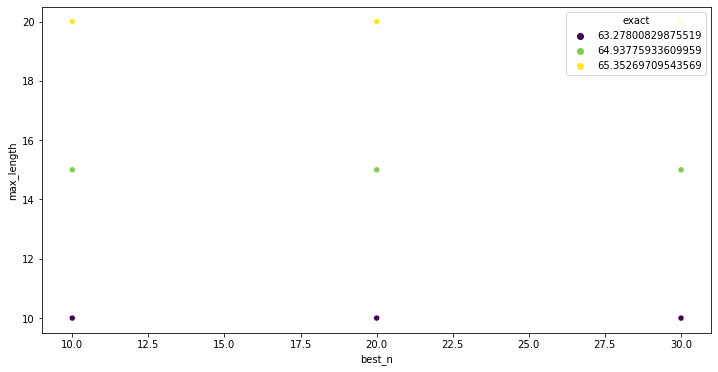

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'best_n' , y = 'max_length' , data = df , hue = 'exact' , palette = 'viridis')

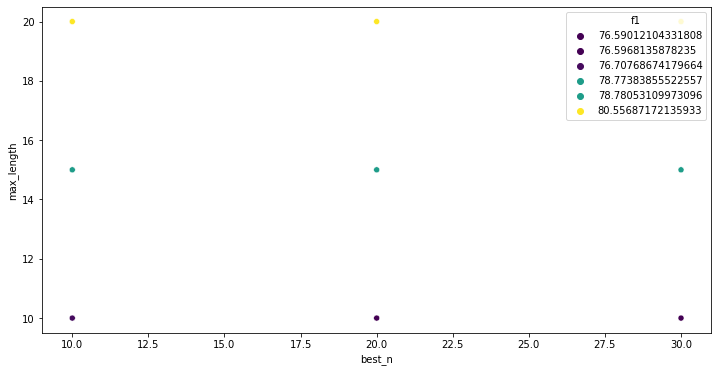

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.scatterplot(x = 'best_n' , y = 'max_length' , data = df , hue = 'f1' , palette = 'viridis')

In [78]:
references[15]

{'answers': {'answer_start': [390], 'text': ['بایرن مونیخ']}, 'id': 1719487.0}

In [79]:
formatted_predictions[15]

{'id': 1719487.0, 'no_answer_probability': 0.0, 'prediction_text': 'آینتراخت'}